In [150]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector,Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [151]:
def entangle_pair(qc,a,b):
    """Bell pair creation"""
    qc.h(a)
    qc.cnot(a,b)

In [152]:
def alice_ops(qc,psi,a):
    """Operations performed by alice on her two qubits"""
    qc.cnot(psi,a)
    qc.h(psi)

In [153]:
def measure(qc,a,b):
    """Alice measures both qubits and sends information through a classical channel"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [154]:
def bob_ops(qc,b,crz,crx):
    """Bob performs X-Gate and Z-Gate on his qubit based on the classical bits received"""
    qc.x(b).c_if(crx,1)
    qc.z(b).c_if(crz,1)

In [155]:
# Quantum Teleportation circuit with 3 qubits
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1,name="crz")
crx = ClassicalRegister(1,name="crx")
qc = QuantumCircuit(qr,crz,crx)

<IPython.core.display.Latex object>

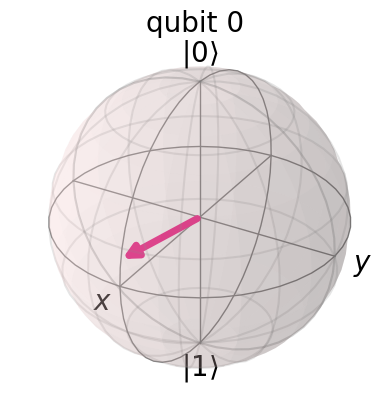

In [156]:
# Arbitrary state psi to be teleported to Bob
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

In [157]:
# Intialize instruction + unitary gates are used to set the qubit to the arbitrary state
init_gate = Initialize(psi)
init_gate.label = "init"

# Inverse of the init gate to later verify the teleportation circuit
inverse_init_gate = init_gate.gates_to_uncompute()

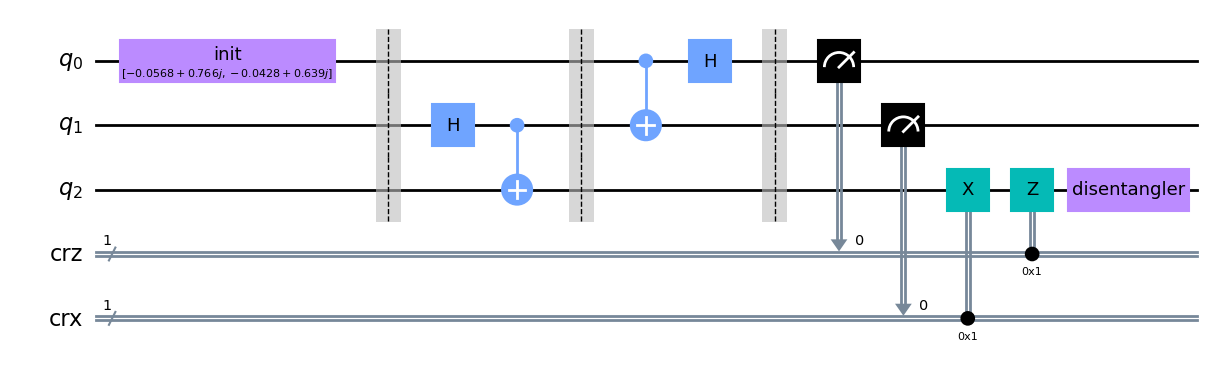

In [158]:
# Initializing the qubit to be teleported
qc.append(init_gate,[0])
qc.barrier()

# Entangling Alice's and Bob's qubits
entangle_pair(qc,1,2)
qc.barrier()

# Alice performs her operations
alice_ops(qc,0,1)

# Alice measures and sends the measurement to Bob classically
measure(qc,0,1)

# Bob performs operations based on classical bits received
bob_ops(qc,2,crz,crx)

# If the teleportation worked, applying the inverse gates to Bob's qubit should set the qubit to |0>
qc.append(inverse_init_gate,[2])

qc.draw(output='mpl')



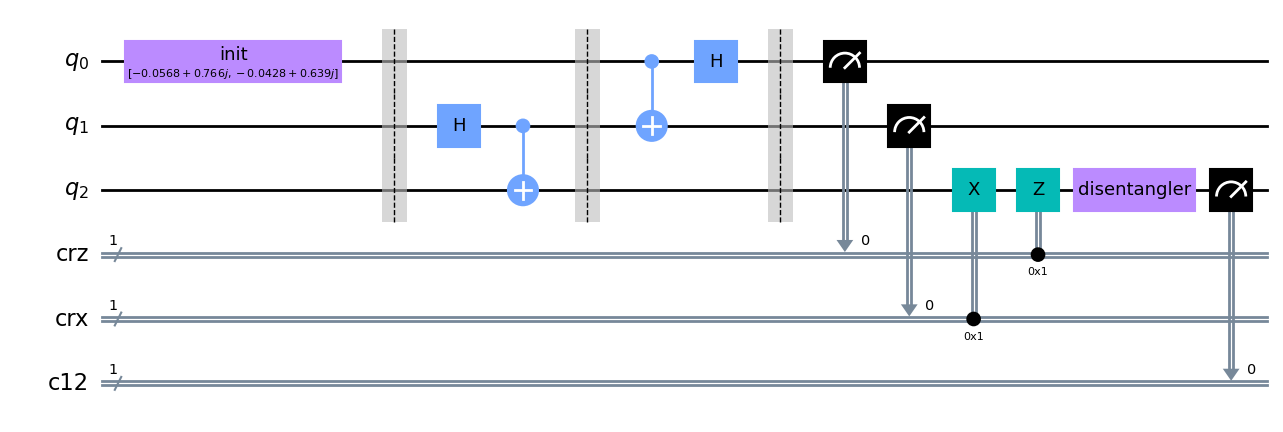

In [159]:
# Measuring Bob's qubit
result = ClassicalRegister(1)
qc.add_register(result)
qc.measure(2,2)
qc.draw(output='mpl')

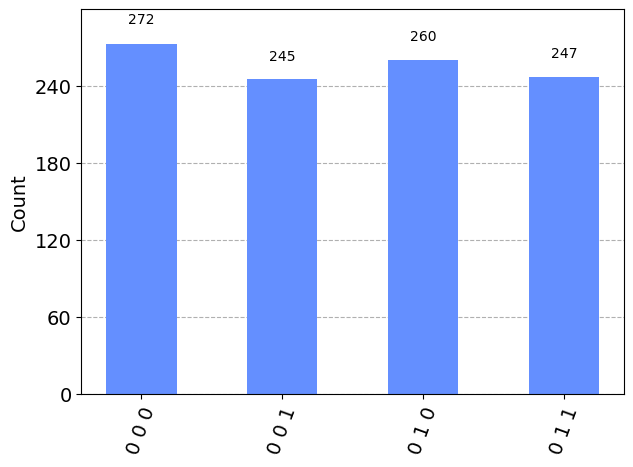

In [160]:
#Bob's qubit is always in the state |0>
sim = Aer.get_backend('aer_simulator')
tqc = transpile(qc,sim)
tqc.save_statevector()
counts = sim.run(tqc).result().get_counts()
plot_histogram(counts)